In [2]:
import warnings
warnings.filterwarnings("ignore")
import glob
import torch
import time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
from IPython.display import clear_output

In [3]:
import plotly
from plotly.offline import iplot
import plotly.graph_objs as go

In [4]:
plotly.offline.init_notebook_mode(connected=True)

In [5]:
import sys
sys.path.append("../pyfiles/")
from dataset import *
from util import *
from model import *

# Get celebA dataset

In [6]:
label_discription = [
    "male, smiling",
    "male, not smiling",
    "female, smiling",
    "female, not smiling"
]

In [7]:
root = "./../../dataset/celebA/img/"
label_root = "./../../dataset/celebA/label_folder/"

In [8]:
# 1 5 o clock shadow
# 11 blurry
# 14 chubby
# 15 double chin
# 16 eyeglasses
# 17 goatee
# 21 male
# 23 mustache
# 25 No_Beard
# 31 sideburns
# 32 smiling
# 36 wearing hat
# 40 young
dataset_label = {}
dataset_label["existed"] = [25] 
dataset_label["delete"] = [1, 11, 14, 15, 16, 17, 23, 31, 36] 
dataset_label["class"] = [21, 32] 

In [9]:
classes = tuple(range(2**len(dataset_label["class"])))
cl = get_class_label(len(dataset_label["class"]))
classes

(0, 1, 2, 3)

In [10]:
normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])

transform = {}
transform["train"] = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    normalize,
])
    
transform["test"] = transforms.Compose([
    transforms.CenterCrop((178, 178)),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    normalize,
])

In [11]:
each_train_num = 10000000
each_val_num = 0
each_test_num = 100
dataset = FaceDataset(root, label_root, transform["train"], dataset_label, classes, data_type="train", train_num=each_train_num, val_num=each_val_num, test_num=each_test_num)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=256, shuffle=True)
testset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="test", train_num=each_train_num, val_num=each_val_num, test_num=each_test_num)
len(dataset), len(testset)

(134530, 400)

0


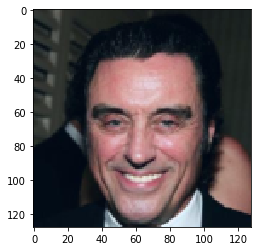

In [12]:
data = dataloader.dataset[24]
img = data[0]
image = image_from_output(torch.reshape(img, (1,img.shape[0],img.shape[1],img.shape[2])))[0]
print(data[1])
plt.imshow(image)

# Preparation

## Additional Model 

In [13]:
def do_test(net, testloader, device="cuda", mode="eval"):
    if mode=="train":
        net.train()
    elif mode=="eval":
        net.eval()
    else:
        return None
    labels = np.array([])
    with torch.no_grad():
        for itr, data in enumerate(testloader):
            images = data[0].to(device)
            label = cuda2numpy(data[1])
            output = cuda2numpy(net(images))
            if itr==0:
                outputs = output
            else:
                outputs = np.concatenate([outputs, output], axis=0)
            labels = np.append(labels, label)
    return labels, outputs

In [14]:
epoch_num = 301
lr = 0.001
save_parameter = True # do you wanna save parameters ?
test_interval = 3 # the interval among validation check
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
from torchvision import models

In [17]:
devices = [0,1,2,3]
net = models.inception_v3(pretrained=False, aux_logits=False)
net.fc = nn.Linear(in_features=2048, out_features=len(classes))
net = net.to(device)
net.apply(weights_init)
net = nn.DataParallel(net, devices)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

## train

In [19]:
each_train_num = 10000
each_val_num = 1000
each_test_num = 100
train_batch = 512
val_batch = 512

dataset = FaceDataset(root, label_root, transform["train"], dataset_label, classes, data_type="train", train_num=each_train_num, val_num=each_val_num, test_num=each_test_num)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=train_batch, shuffle=True)

valset = FaceDataset(root, label_root, transform["test"], dataset_label, classes, data_type="val", train_num=each_train_num, val_num=each_val_num, test_num=each_test_num)
valloader = torch.utils.data.DataLoader(dataset=valset, batch_size=train_batch, shuffle=False)
len(dataset), len(valset)

(40000, 4000)

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix

64
test acc in 63 : 0.89575
best acc is   : 0.899 in epoch51


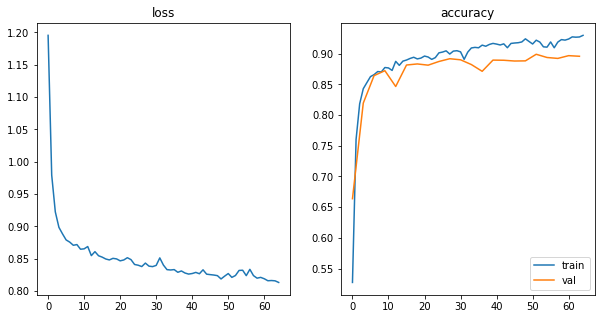

In [ ]:
net.train()
losses_epoch = []
acc_epoch = []
acc_test_list = []
best_epoch = 0
best_acc = 0
for epoch in range(epoch_num):
    losses = []
    accs = []
    for itr, data in enumerate(dataloader):
        net.train()
        x = data[0].to(device)
        label = data[1].to(device)
        optimizer.zero_grad()
        y = F.softmax(net(x))
        loss = criterion(y, label)
        loss.backward()
        optimizer.step()
        loss = cuda2numpy(loss)
        label = cuda2numpy(label)
        y = cuda2numpy(y)
        acc = (np.argmax(y, axis=1) == label).sum().item()/len(label)
        losses.append(loss)
        accs.append(acc)
    scheduler.step()
    losses_epoch.append(np.mean(np.array(losses)))
    acc_epoch.append(np.mean(np.array(accs)))
    if epoch%test_interval==0:
        labels, outputs = do_test(net, valloader, device, "eval")
        pred_labels = np.argmax(outputs, axis=1) 
        acc_test = accuracy_score(labels, pred_labels)
        acc_test_list.append(acc_test)
        if best_acc < acc_test:
            best_acc = acc_test
            best_epoch = epoch
            
    clear_output(wait=True)
    print(epoch)
    print(f"test acc in {epoch//test_interval*test_interval} : {acc_test}")
    print(f"best acc is   : {best_acc} in epoch{best_epoch}")
    
    if save_parameter:
        if epoch%test_interval==0:
            torch.save(net.module.state_dict(), f"./instant_model_parameter/facial_recognizer_inception_lr{lr}_epoch{epoch}.pth")
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,2,1)
    ax.plot(losses_epoch)
    ax.set_title("loss")
    ax = fig.add_subplot(1,2,2)
    ax.plot(acc_epoch, label="train")
    ax.plot(np.arange(epoch//test_interval+1)*test_interval, acc_test_list, label="val")
    ax.legend()
    ax.set_title('accuracy')
    plt.show()

In [301]:
net = models.inception_v3(pretrained=False, aux_logits=False)
net.fc = nn.Linear(in_features=2048, out_features=len(classes))
net = net.to(device)

In [302]:
load_parameter = True
# model_path = "model_parameters/Mpaper/72/facial_recognizer_lr0.0001_epoch51.pth"
model_path = "instant_model_parameter/facial_recognizer_inception_lr0.001_epoch222.pth"
if load_parameter:
    model = torch.load(model_path) 
    net.load_state_dict(model)

---
Evaluate it many times.

---

In [29]:
# ----- adjustable parameters ----- #
test_num = 10
# --------------------------------- #

acc_list = []
cm_list = []
for i in range(test_num):
    print(i)
    labels, outputs = do_test(net, testloader, device, "eval")
    pred_labels = np.argmax(outputs, axis=1) 
    acc_test = accuracy_score(labels, pred_labels)
    acc_list.append(acc_test)
    cm = confusion_matrix(labels, pred_labels, labels=np.arange(len(classes)))
    cm_list.append(cm)
    clear_output(wait=True)
print(f"test acc is : {np.mean(acc_list)}")

test acc is : 0.9075000000000001


---
Check the detail (confusion matrix)

---

In [32]:
############ https://www.kaggle.com/grfiv4/plot-a-confusion-matrix #############
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

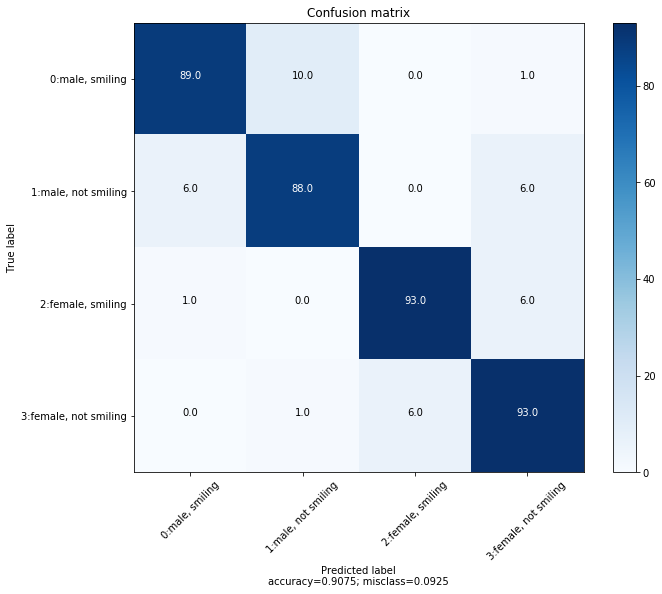

In [33]:
class_idx_lbl = label_discription.copy()
for i in range(len(label_discription)):
    class_idx_lbl[i] = f"{i}:{label_discription[i]}"
        
cm = np.mean(np.array(cm_list), axis=0)
plot_confusion_matrix(cm, class_idx_lbl, normalize=False)

---
The accuracy is quite good enough. The model seems to have difficulty in classification of tops

---

## Misclassification
---
It's also essential to observe the mis-classification in order to improve your model or to find some flaws of the model.

---


the samples of 'female, smiling' which are classified as 'female, not smiling''



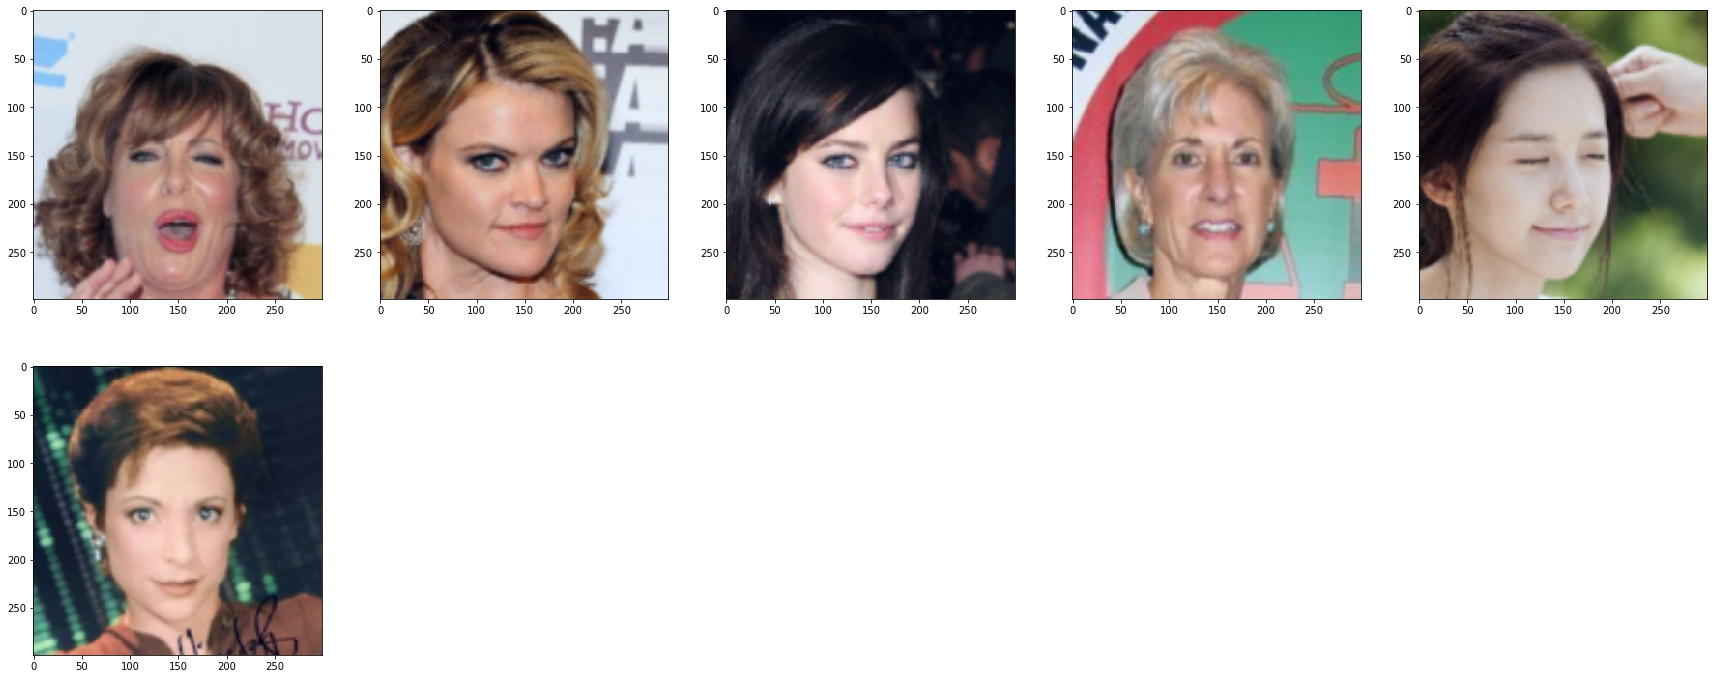

In [34]:
# ----- adjustable parameters ----- #
true_class = 2
misclassified_class = 3
display_num = 10
# --------------------------------- #

print("")
print(f"the samples of '{label_discription[true_class]}' which are classified as '{label_discription[misclassified_class]}''")
print("")
fig = plt.figure(figsize=(30, 12))
miss_index_list = np.arange(len(labels))[np.array(np.array(pred_labels==misclassified_class, dtype=np.int) * np.array(labels==true_class, dtype=np.int), dtype=np.bool)]
for i in range(len(miss_index_list[:display_num])):
    ax = fig.add_subplot(2, 5, i+1)
    x, label = testset[miss_index_list[i]]
    ax.imshow(image_from_output(x[np.newaxis])[0])

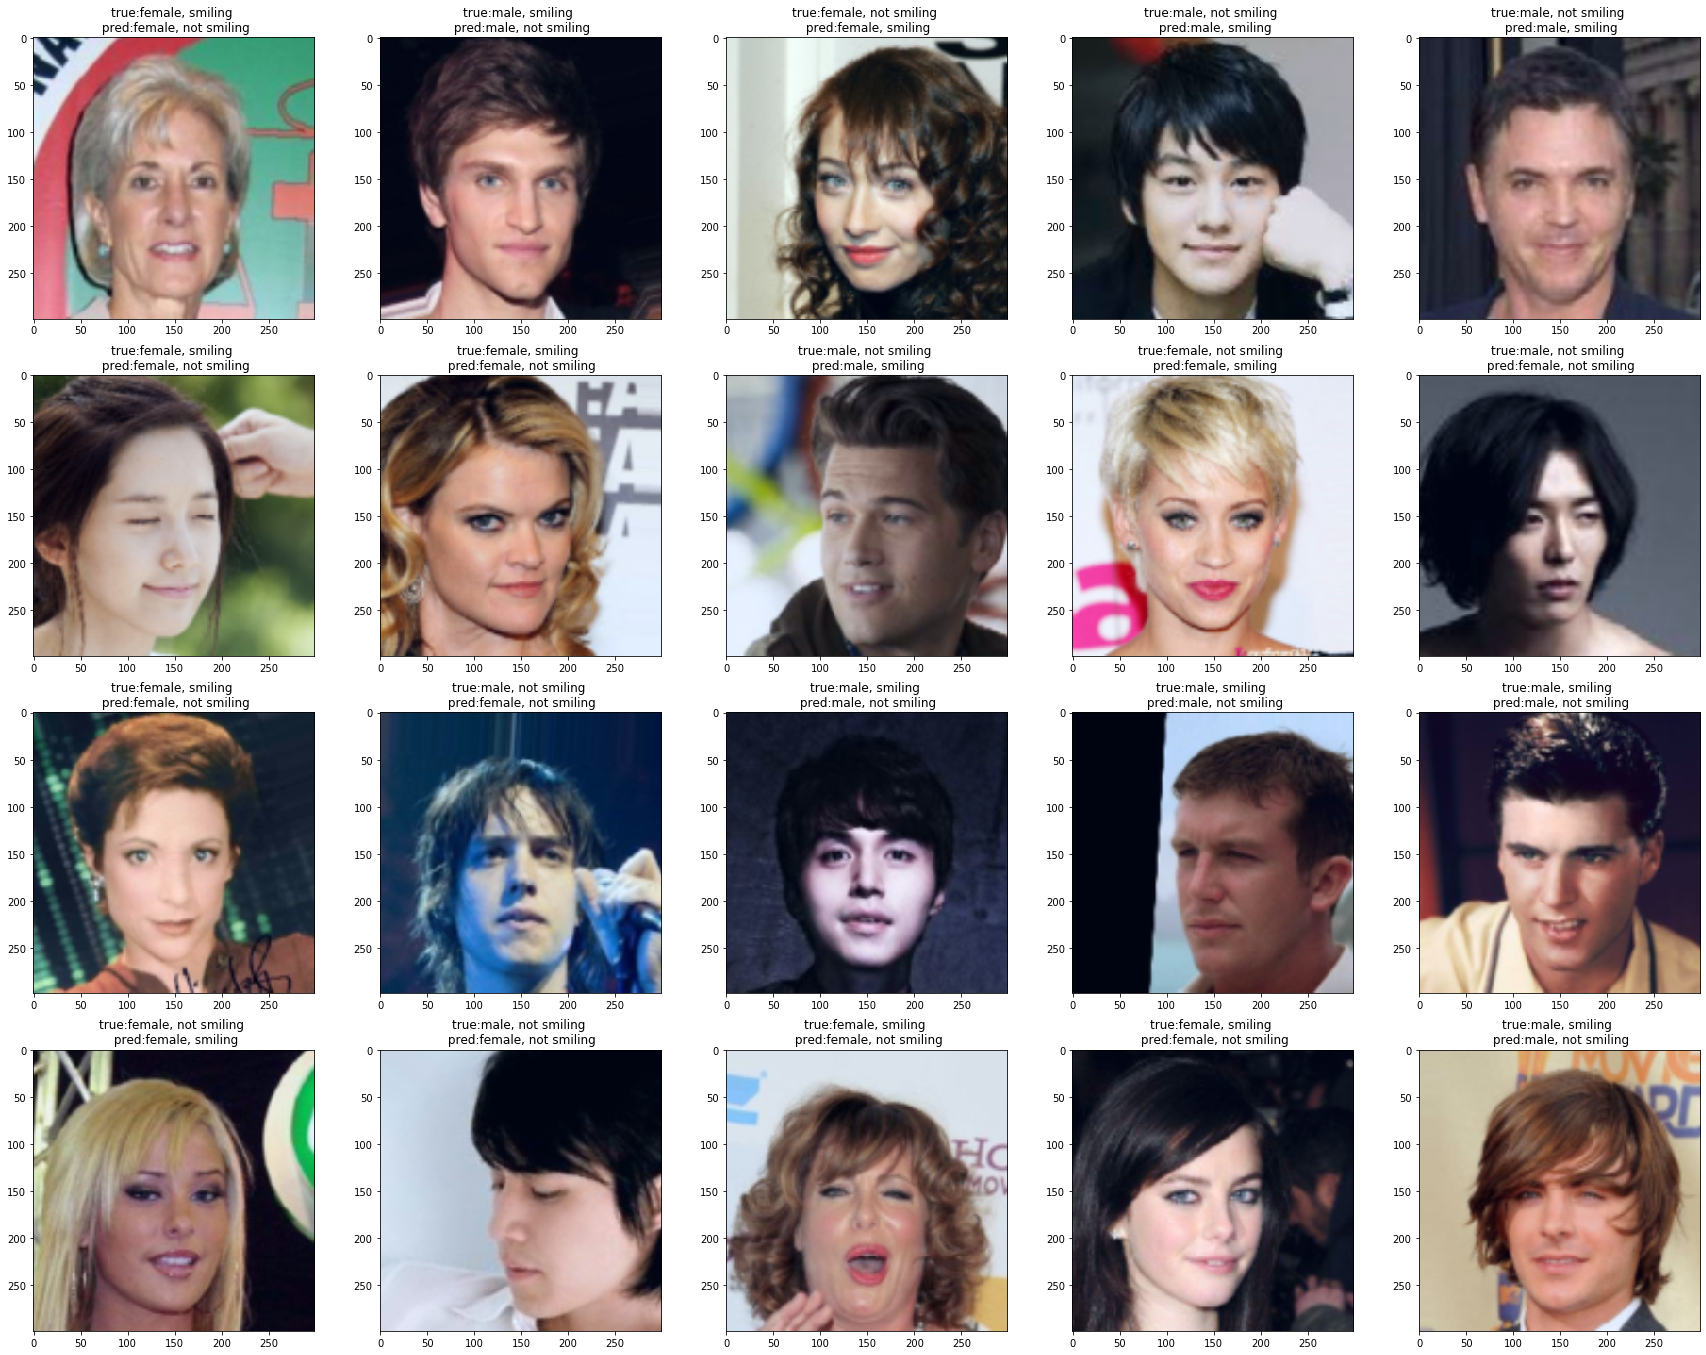

In [35]:
# ----- adjustable parameters ----- #
display_num = 20
# --------------------------------- #

index_bool = pred_labels!=labels
indexes = np.random.choice(np.arange(len(labels))[index_bool], size=min(display_num,index_bool.sum()), replace=False)

fig = plt.figure(figsize=(30, 6*(len(indexes)//5+1)))
for i in range(len(indexes)):
    idx = indexes[i]
    ax = fig.add_subplot(len(indexes)//5+1, 5, i+1)
    x, label = testset[idx]
    ax.imshow(image_from_output(x[np.newaxis])[0])
    title = f"true:{label_discription[int(labels[idx])]} \n pred:{label_discription[pred_labels[idx]]}"
    ax.set_title(title, )